# MNIST dataset classification

### Import dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Normalize data, create dataset, create dataloader

In [3]:
!wget https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-04-28 08:59:52--  https://s3.amazonaws.com/img-datasets/mnist.npz
Caricato certificato CA "/etc/ssl/certs/ca-certificates.crt"

Risoluzione di s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.184
Connessione a s3.amazonaws.com (s3.amazonaws.com)|52.217.229.184|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 11490434 (11M) [application/octet-stream]
Salvataggio in: «mnist.npz.3»

mnist.npz.3         100%[===================>]  10,96M   224KB/s    in 31s     

2022-04-28 09:00:24 (361 KB/s) - «mnist.npz.3» salvato [11490434/11490434]



In [86]:
"""
The dataset is downloaded as .npz file.
When an .npz file is loaded with np.load()
the result is a dictionary-like object whose
elements are acccessible with data["label"].
The files attribute returns a list with
the possible labels.
Example:

> data = np.load("file.npz")
> print(data.files)
"""

def return_ds():
    path = "mnist.npz"

    ds = np.load(path)
    print(f"loaded dataset with labels {ds.files}\n\
Subsets are returned in the following order:\n\
x_train, x_test, y_train, y_test\n")

    return ds[ds.files[1]], ds[ds.files[0]], ds[ds.files[2]], ds[ds.files[3]]

In [87]:
# Load dataset
x_train, x_test, y_train, y_test = return_ds()

print(f"Training inputs shape: {x_train.shape}")
print(f"Validation inputs shape: {x_test.shape}")
print(f"Training outputs shape: {y_train.shape}")
print(f"Validation outputs shape: {y_test.shape}")

loaded dataset with labels ['x_test', 'x_train', 'y_train', 'y_test']
Subsets are returned in the following order:
x_train, x_test, y_train, y_test

Training inputs shape: (60000, 28, 28)
Validation inputs shape: (10000, 28, 28)
Training outputs shape: (60000,)
Validation outputs shape: (10000,)


In [88]:
# Normalize and convert to tensor
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

x_train, x_test, y_train, y_test = map(
                                        torch.tensor,
                                        (x_train, x_test, y_train, y_test)
                                        )

torch.set_default_dtype(torch.float32)
x_train = x_train.float()
x_test = x_test.float()
y_train = y_train.long()
y_test = y_test.long()

In [127]:
# Create datasets and dataloader
batch_sz = 100

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_test, y_test)
mlp_train_ds = TensorDataset(x_train.reshape(-1, 28*28), y_train)
mlp_valid_ds = TensorDataset(x_test.reshape(-1, 28*28), y_test)

train_dl = DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_sz*4)
mlp_train_dl = DataLoader(mlp_train_ds, batch_size=batch_sz, shuffle=True)
mlp_valid_dl = DataLoader(mlp_valid_ds, batch_size=batch_sz*4)

In [128]:
x_test.reshape(-1, 28*28).shape

torch.Size([10000, 784])

In [129]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 20)
        self.layer2 = nn.Linear(20,15)
        self.layer3 = nn.Linear(15, 10)

    def forward(self, input):
        x = F.relu(self.layer1(input))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [130]:
# define a cross entropy loss (or an mse loss)

loss_func = F.cross_entropy
# loss_func = F.mse_loss

In [158]:
# define functions for fitting model and evaluating

def step(model, xb, yb, loss_func, opt):
    loss = loss_func(model(xb), yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

    return loss


def fit(model, loss_func, train_dl, val_dl, epochs, opt):
    for epoch in range(epochs):
        model.train()
        for train_xb, train_yb in train_dl:
            loss = step(model, train_xb, train_yb, loss_func, opt)

        print(f"Training loss at epoch {epoch}: {loss:.2f}")

        model.eval()
        with torch.no_grad():
            loss = 0
            for val_xb, val_yb in val_dl:
                loss += loss_func(model(val_xb), val_yb)
            loss = loss/len(val_dl)
            print(f"Validation loss at epoch {epoch}: {loss:.2f}\n")


def eval_single_input(model, input):
    out = model(input)
    return torch.argmax(out)


def eval(model, x_test, y_test):
    n_success = 0
    for n, (x, y) in enumerate(zip(x_test, y_test)):
        out_model = eval_single_input(model, x)
        n_success += (out_model == y)

    return n_success/n
    


In [132]:
# instantiate a model and an optimizer

lr = 0.1

mlp_model = MLP()
optim = opt.SGD(mlp_model.parameters(), lr=lr)

In [133]:
# fit the model

fit(mlp_model, loss_func, mlp_train_dl, mlp_valid_dl, 10, optim)

Training loss at epoch 0: 0.16
Validation loss at epoch 0: 0.24

Training loss at epoch 1: 0.20
Validation loss at epoch 1: 0.18

Training loss at epoch 2: 0.20
Validation loss at epoch 2: 0.16

Training loss at epoch 3: 0.07
Validation loss at epoch 3: 0.15

Training loss at epoch 4: 0.11
Validation loss at epoch 4: 0.16

Training loss at epoch 5: 0.13
Validation loss at epoch 5: 0.14

Training loss at epoch 6: 0.14
Validation loss at epoch 6: 0.16

Training loss at epoch 7: 0.18
Validation loss at epoch 7: 0.14

Training loss at epoch 8: 0.09
Validation loss at epoch 8: 0.14

Training loss at epoch 9: 0.08
Validation loss at epoch 9: 0.14



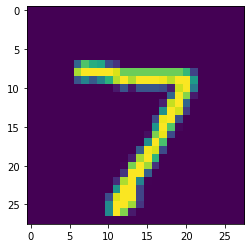

In [151]:
im = x_test[0]
plt.imshow(im)

In [155]:
eval_single_input(mlp_model, im.view(-1, 28*28))

tensor(7)

In [159]:
print(eval(mlp_model, x_test.view(10000, -1), y_test.view(10000, -1)))

tensor([0.9592])
